In [1]:
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import slack_notification as sn

In [2]:
class SketchModel(nn.Module):
    """
    https://github.com/HPrinz/sketch-recognition
    input size: (225. 225)
    """
    def __init__(self):
        super(SketchModel, self).__init__()
        self.output_num = 10
        self.filer_num = 64
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = self.conv_block(1, self.filer_num*1, kernel_size=15, stride=3, padding=0, act_fn=self.act)
        self.conv2 = self.conv_block(self.filer_num*1, self.filer_num*2, kernel_size=3, stride=1, padding=0, act_fn=self.act)
        self.conv3 = self.conv_block(self.filer_num*2, self.filer_num*4, kernel_size=3, stride=1, padding=1, act_fn=self.act)
        self.conv4 = self.conv_block(self.filer_num*4, self.filer_num*4, kernel_size=3, stride=1, padding=1, act_fn=self.act)
        self.conv5 = self.conv_block(self.filer_num*4, self.filer_num*4, kernel_size=3, stride=1, padding=1, act_fn=self.act)
        self.conv6 = self.conv_block(self.filer_num*4, self.filer_num*8, kernel_size=7, stride=1, padding=0, act_fn=self.act)
        self.conv7 = self.conv_block(self.filer_num*8, self.filer_num*8, kernel_size=1, stride=1, padding=0, act_fn=self.act)
        
        self.conv8 = self.conv_block(self.filer_num*8, 50, kernel_size=1, stride=1, padding=0, act_fn=self.act)
        self.out = nn.Sequential(
            nn.Linear(50, self.output_num),
            nn.Sigmoid(),
        )
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.drop = nn.Dropout2d(p=0.25)
        
    def forward(self, input):
        h = self.pool(self.conv1(input))
        h = self.pool(self.conv2(h))
        h = self.pool(self.conv5(self.conv4(self.conv3(h))))
        h = self.drop(self.conv6(h))
        h = self.conv8(self.drop(self.conv7(h)))
        h = self.out(self.flatten(h))
        return h
    
    def conv_block(self, in_dim, out_dim, kernel_size, stride, padding, act_fn):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding),
            act_fn,
        )
    
    def flatten(self, x):
        bs = x.size()[0]
        return x.view(bs, -1)

In [3]:
data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(225),
    transforms.ToTensor(),
])

In [4]:
train_data = torchvision.datasets.ImageFolder(root='./train', transform=data_transform)
train_data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=4)    
test_data = torchvision.datasets.ImageFolder(root='./test', transform=data_transform)
test_data_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=4)    

In [5]:
model = SketchModel().cuda()
lr = 0.0001
optim = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().cuda()

In [8]:
def loss_plot(train_loss, test_loss, name):
    epoch = np.arange(len(train_loss))
    plt.clear()
    plt.plot(epoch, train_loss, label='train')
    plt.plot(epoch, test_loss, label='test')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('./{}/loss.png'.format(name))
    sn.upload_image('./{}/loss.png'.format(name))
        
def train(epoch, name):
    
    if not os.path.exists(name):
        os.mkdir(name)
    train_loss = np.array([])
    test_loss = np.array([])
    for i in range(epoch):
        
        loss_per_epoch = 0
        acc = 0
        for batch_idx, (imgs, labels) in enumerate(train_data_loader):
            model.train()
            optim.zero_grad()
            imgs = imgs.cuda().float()
            labels = labels.cuda().long()
            estimated = model.forward(imgs)
            loss = criterion(estimated, labels)
            loss.backward()
            optim.step()
            loss_per_epoch += loss.data
            acc += torch.sum(labels == torch.argmax(estimated, dim=1)).cpu().numpy()
            
        train_loss = np.append(train_loss, loss_per_epoch)
        print("epoch: {}, train_loss: {}".format(i, train_loss[-1]))
        print("train_acc: {}".format(acc/len(train_data)))
        sn.send_notification("epoch: {}, train_loss: {}".format(i, train_loss[-1]))
        sn.send_notification("train_acc: {}".format(acc/len(train_data)))
    
        loss_per_epoch = 0
        acc = 0
        for batch_idx, (imgs, labels) in enumerate(test_data_loader):
            model.eval()
            imgs = imgs.cuda().float()
            labels = labels.cuda().long()
            estimated = model.forward(imgs)
            loss = criterion(estimated, labels)
            loss_per_epoch += loss.data*len(train_data)/len(test_data)
            acc += torch.sum(labels == torch.argmax(estimated, dim=1)).cpu().numpy()
            
        test_loss = np.append(test_loss, loss_per_epoch)
        print("epoch: {}, test_loss: {}".format(i, test_loss[-1]))
        print("test_acc: {}".format(acc/len(test_data)))
        sn.send_notification("epoch: {}, test_loss: {}".format(i, test_loss[-1]))
        sn.send_notification("test_acc: {}".format(acc/len(test_data)))
        loss_plot(train_loss, test_loss)
        
        torch.save(model.state_dict(), './{}/epoch_{}'.format(name, i))

epoch: 0, train_loss: 403.1928405761719
train_acc: 0.08857142857142856
epoch: 0, test_loss: 402.98016357421875
test_acc: 0.1
epoch: 1, train_loss: 403.0185852050781
train_acc: 0.09
epoch: 1, test_loss: 402.88153076171875
test_acc: 0.1
epoch: 2, train_loss: 405.1301574707031
train_acc: 0.11285714285714285
epoch: 2, test_loss: 402.48291015625
test_acc: 0.11
epoch: 3, train_loss: 399.5704650878906
train_acc: 0.15
epoch: 3, test_loss: 387.3721923828125
test_acc: 0.12
epoch: 4, train_loss: 371.76129150390625
train_acc: 0.24857142857142858
epoch: 4, test_loss: 358.8086853027344
test_acc: 0.27
epoch: 5, train_loss: 358.8052062988281
train_acc: 0.2642857142857143
epoch: 5, test_loss: 353.1512756347656
test_acc: 0.39
epoch: 6, train_loss: 342.82318115234375
train_acc: 0.3585714285714286
epoch: 6, test_loss: 342.006103515625
test_acc: 0.33
epoch: 7, train_loss: 336.95806884765625
train_acc: 0.37142857142857144
epoch: 7, test_loss: 331.8789978027344
test_acc: 0.49
epoch: 8, train_loss: 331.366790

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epoch: 21, train_loss: 286.249755859375
train_acc: 0.7242857142857143
epoch: 21, test_loss: 308.60748291015625
test_acc: 0.54
epoch: 22, train_loss: 285.3438720703125
train_acc: 0.7371428571428571
epoch: 22, test_loss: 313.4881286621094
test_acc: 0.55
epoch: 23, train_loss: 282.4649658203125
train_acc: 0.7728571428571429
epoch: 23, test_loss: 311.7373046875
test_acc: 0.59
epoch: 24, train_loss: 281.7736511230469
train_acc: 0.7885714285714286
epoch: 24, test_loss: 313.78704833984375
test_acc: 0.62
epoch: 25, train_loss: 283.8987731933594
train_acc: 0.77
epoch: 25, test_loss: 306.0093688964844
test_acc: 0.68
epoch: 26, train_loss: 280.4242248535156
train_acc: 0.8
epoch: 26, test_loss: 312.59844970703125
test_acc: 0.54
epoch: 27, train_loss: 280.75946044921875
train_acc: 0.7628571428571429
epoch: 27, test_loss: 311.2945861816406
test_acc: 0.64
epoch: 28, train_loss: 279.8383483886719
train_acc: 0.8057142857142857
epoch: 28, test_loss: 305.6378173828125
test_acc: 0.63
epoch: 29, train_loss

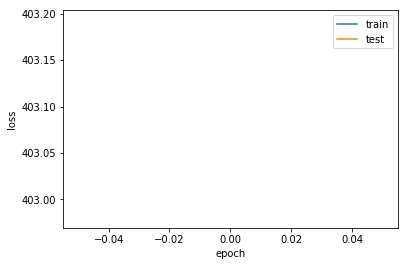

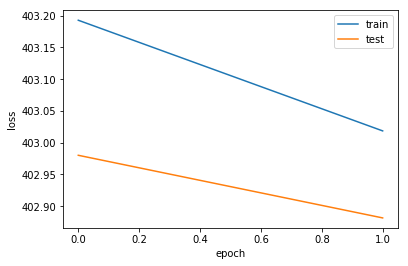

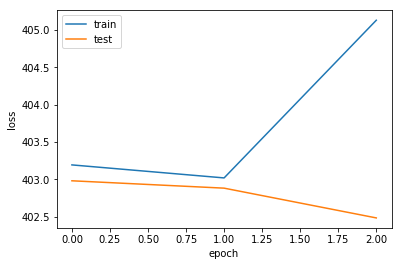

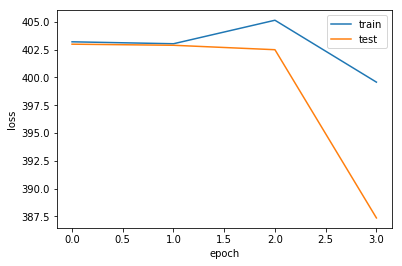

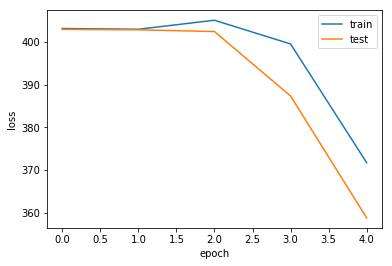

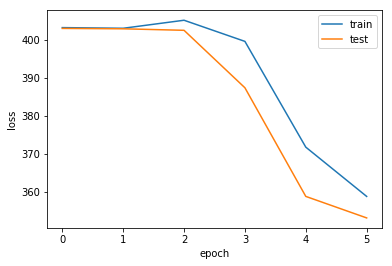

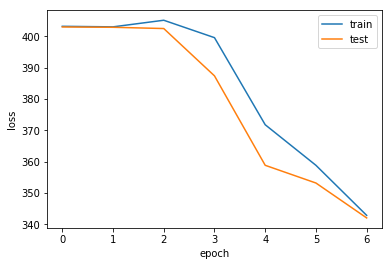

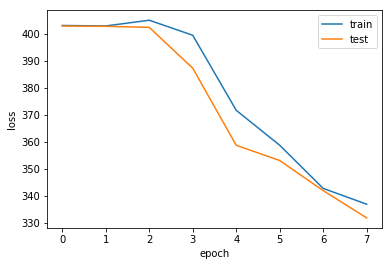

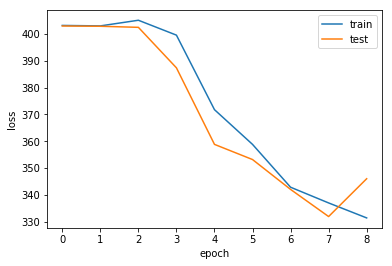

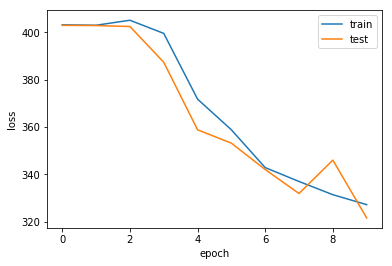

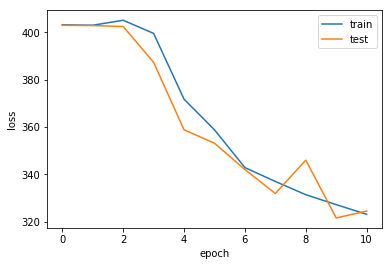

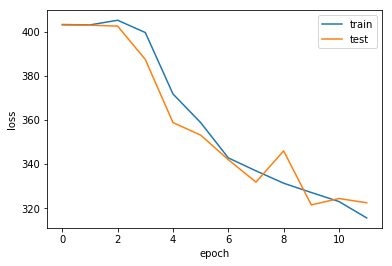

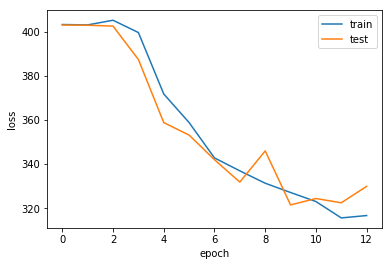

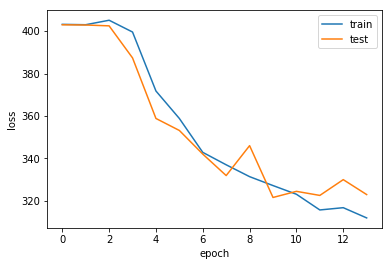

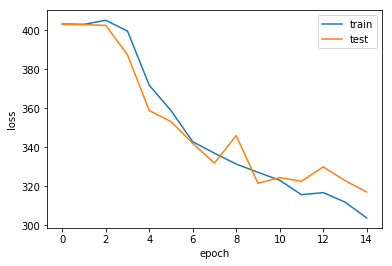

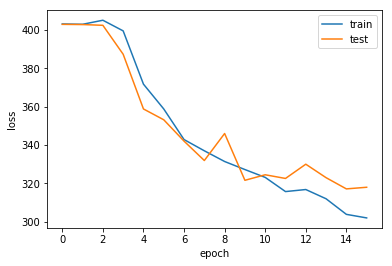

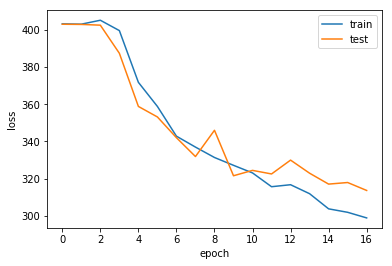

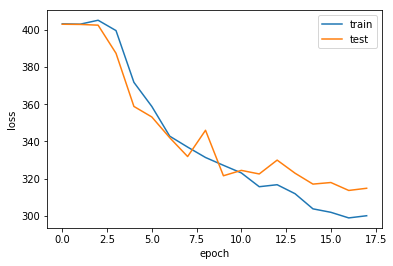

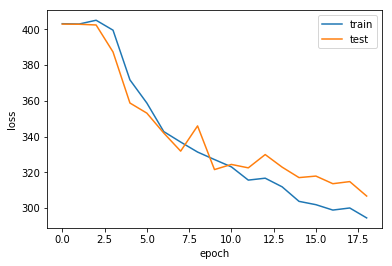

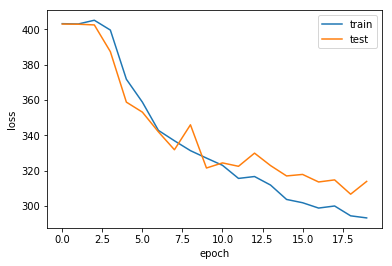

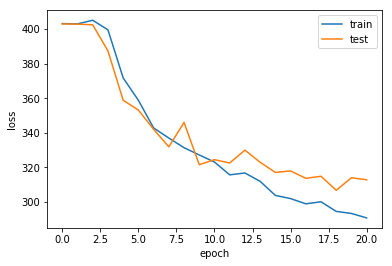

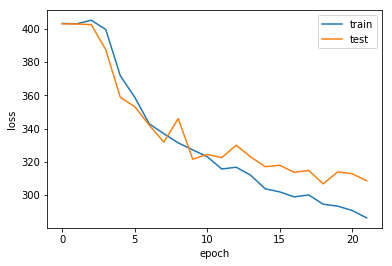

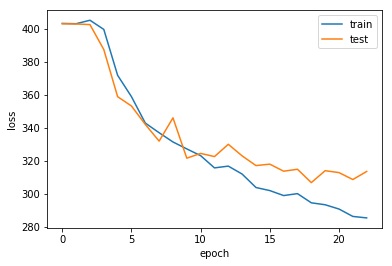

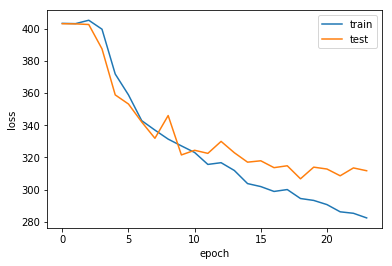

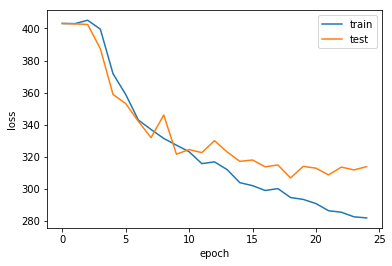

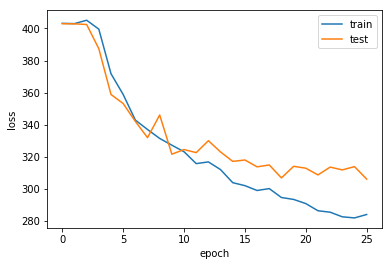

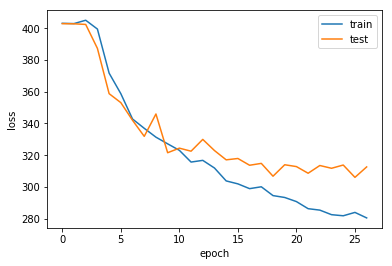

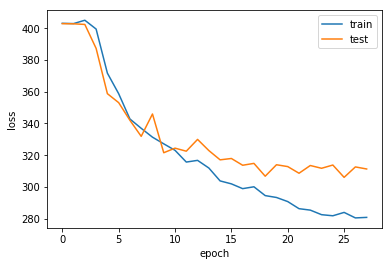

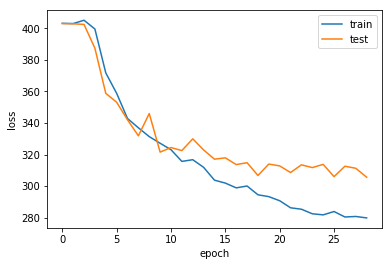

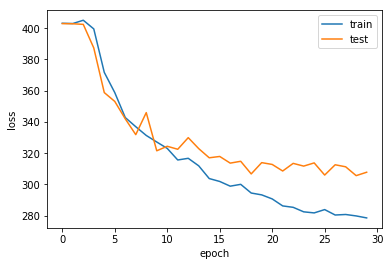

In [7]:
train(30, '1203_2')